In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Additional import for EfficientNet specific preprocessing
from tensorflow.keras.applications.efficientnet import preprocess_input

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Directory paths
train_data_dir = '/content/drive/MyDrive/1. FHNW Classes/2nd Semester/3. Applied Computational Intelligence/Proyecto/brain_tumor/Training'
test_data_dir = '/content/drive/MyDrive/1. FHNW Classes/2nd Semester/3. Applied Computational Intelligence/Proyecto/brain_tumor/Testing'

In [ ]:
# Extract files and labels
def extract_files_labels(directory):
    filepaths = []
    labels = []
    folds = [fold for fold in os.listdir(directory) if os.path.isdir(os.path.join(directory, fold))]
    for fold in folds:
        foldpath = os.path.join(directory, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

In [ ]:
# Load data
train_df = extract_files_labels(train_data_dir)
test_df = extract_files_labels(test_data_dir)

In [ ]:
# Splitting test data further into validation and test sets
valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=123)

In [ ]:
# Data Generators
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
ts_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
#EEfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max')
model = Sequential([
    base_model,
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                         

In [ ]:
#Training Model
epochs = 3
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/3
357/357 [==============================] - 2126s 6s/step - loss: 0.5095 - accuracy: 0.8272 - val_loss: 0.4218 - val_accuracy: 0.8565
Epoch 2/3
357/357 [==============================] - 1614s 5s/step - loss: 0.2377 - accuracy: 0.9195 - val_loss: 0.1233 - val_accuracy: 0.9542
Epoch 3/3
357/357 [==============================] - 1682s 5s/step - loss: 0.1569 - accuracy: 0.9450 - val_loss: 0.0602 - val_accuracy: 0.9725


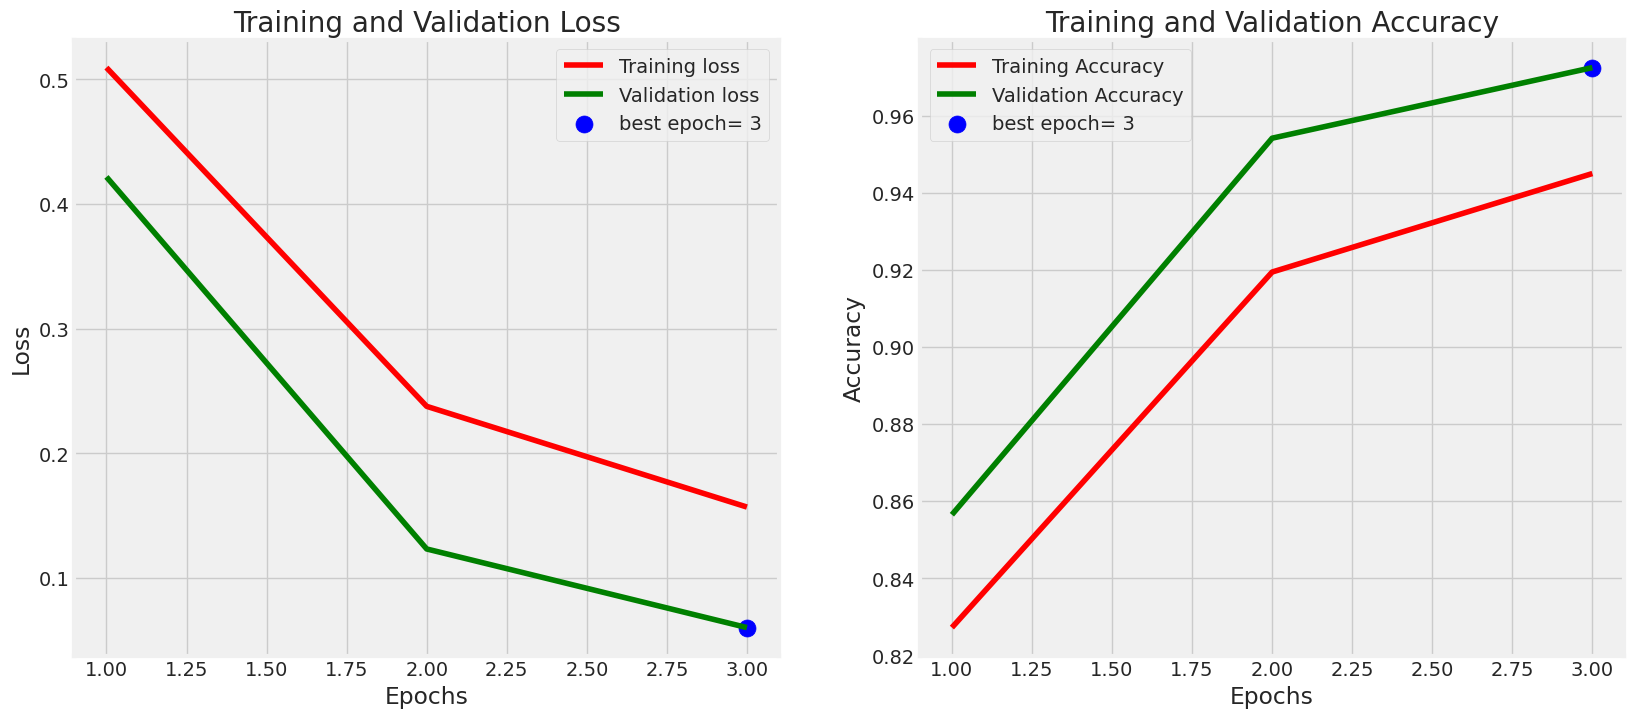

In [ ]:
# Evaluating model
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_gen ,  verbose = 1)
valid_score = model.evaluate(valid_gen ,  verbose = 1)
test_score = model.evaluate(test_gen ,  verbose = 1)

41/41 [==============================] - 219s 5s/step - loss: 0.0690 - accuracy: 0.9802


In [ ]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
cm

array([[131,   6,   0,   2],
       [  3, 149,   0,   1],
       [  0,   0, 200,   0],
       [  0,   1,   0, 163]])

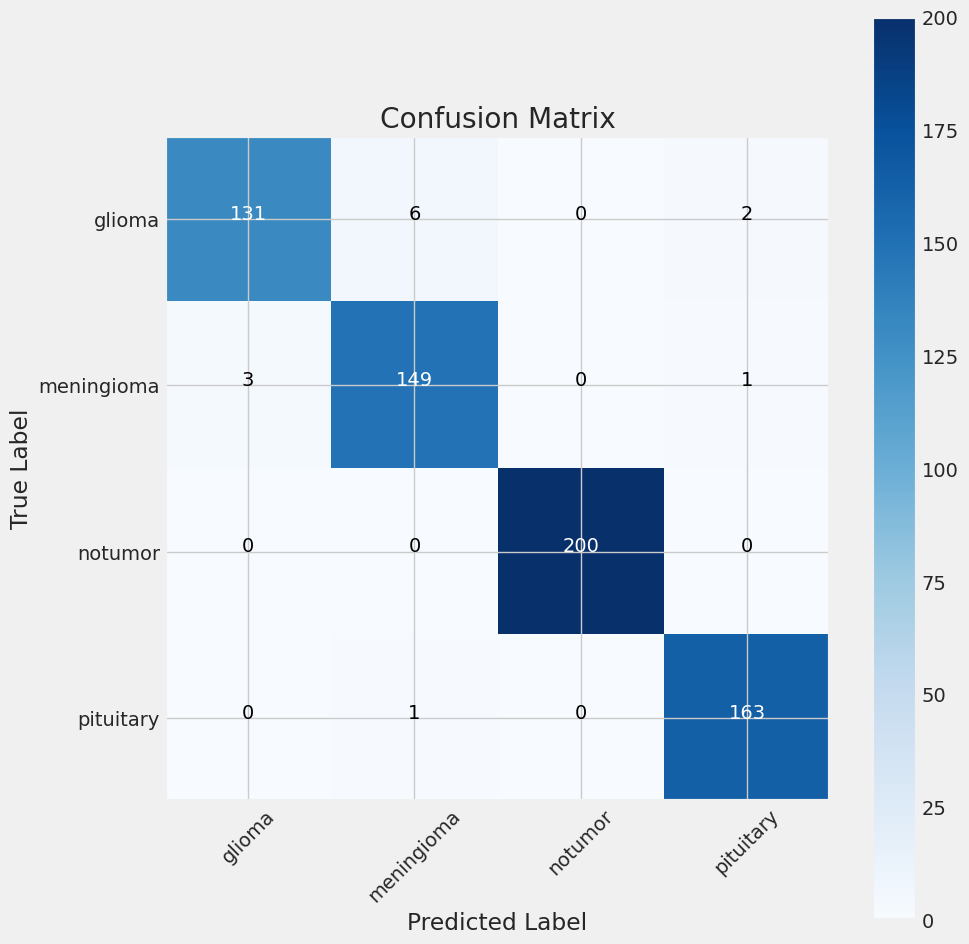

In [ ]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

41/41 [==============================] - 45s 1s/step


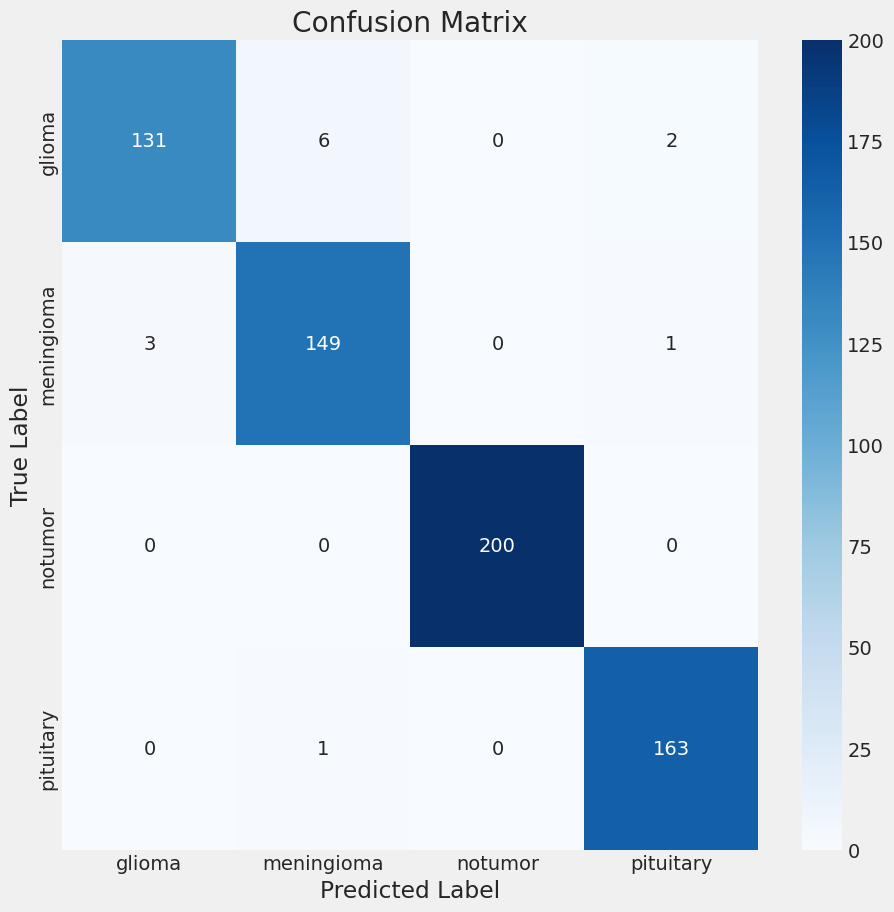

Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.94      0.96       139
  meningioma       0.96      0.97      0.96       153
     notumor       1.00      1.00      1.00       200
   pituitary       0.98      0.99      0.99       164

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656

Accuracy: 0.9802
Class: glioma
 Precision: 0.9776
 Recall: 0.9424
 F1-Score: 0.9597
Class: meningioma
 Precision: 0.9551
 Recall: 0.9739
 F1-Score: 0.9644
Class: notumor
 Precision: 1.0000
 Recall: 1.0000
 F1-Score: 1.0000
Class: pituitary
 Precision: 0.9819
 Recall: 0.9939
 F1-Score: 0.9879


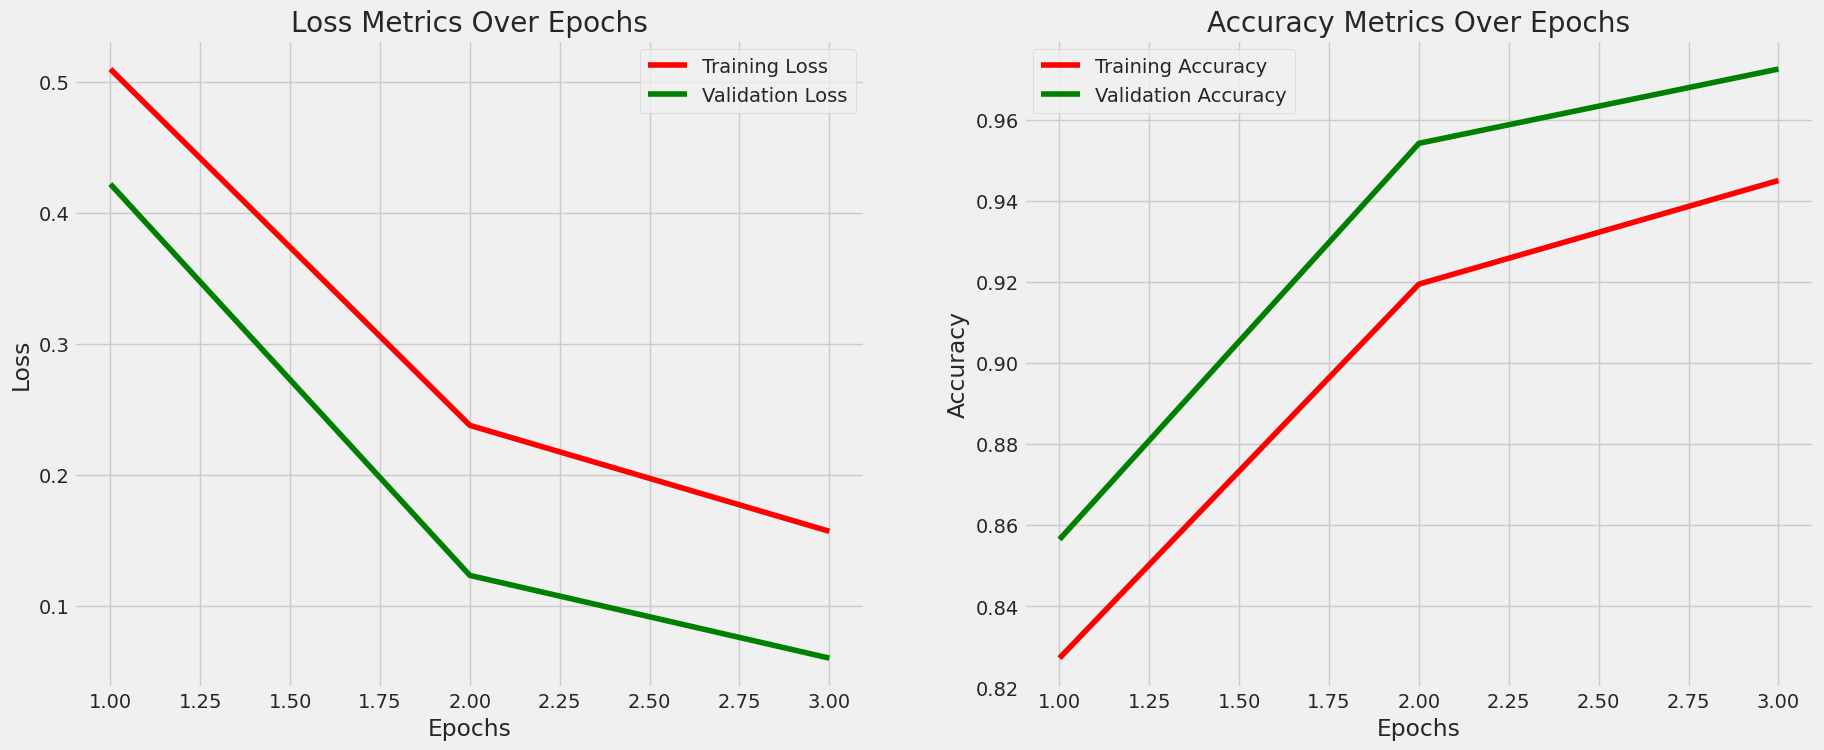

In [ ]:
# Performance Metrics
# Predict the labels for the test set
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# True labels
y_true = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", report)

# Calculate Accuracy, Precision, Recall, and F1-Score
accuracy = np.trace(cm) / np.sum(cm)
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_scores = 2 * precision * recall / (precision + recall)

# Performance metrics output
print(f"Accuracy: {accuracy:.4f}")
for idx, cls in enumerate(classes):
    print(f"Class: {cls}")
    print(f" Precision: {precision[idx]:.4f}")
    print(f" Recall: {recall[idx]:.4f}")
    print(f" F1-Score: {f1_scores[idx]:.4f}")

# Plotting training and validation accuracy and loss curves
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.title('Loss Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Accuracy Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Saving EfficientNet Model
model.save("model_enb0.h5")